In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton

device = torch.device('cuda:0')
steps  = 101
pp   = torch.tensor(.8)
h    = torch.log(pp/(1-pp))/2
k    = 3
d    = 10000
bs   = 10
x    = torch.randn(d, bs, device=device) * d**(1/2)#
xs   = [x]
inv_t  = 2
fp_eqn = lambda x: np.tanh(inv_t * x) - x 
m      = torch.tensor(newton(fp_eqn, 1))

tau  = lambda t: (1-k/d**(1/2))*2*t if t < 1/2 else (1-k/d**(1/2)) + k/d**(1/2) * (2*t-1)
taup = lambda t: (1-k/d**(1/2))*2 if t < 1/2 else k/d**(1/2) * 2

b_over_a = lambda t: tau(t) / (d*(1-tau(t))**2)
W_plus   = torch.exp(h * m) / (2 * torch.cosh(h * m))
W_minus  = torch.exp(-h * m) / (2 * torch.cosh(h * m))
logQp    = lambda x, t: torch.sum(torch.log(1 + m * torch.tanh(x * b_over_a(t))), 0)
logQm    = lambda x, t: torch.sum(torch.log(1 - m * torch.tanh(x * b_over_a(t))), 0)

def cond_exp(x, t):
    # Q_p > Q_m
    pgm = logQp(x, t) >= logQm(x, t)
    Q_mp = torch.exp((logQm(x, t) - logQp(x, t)) * pgm)
    num = W_plus * torch.tanh(inv_t * m + x * b_over_a(t))\
          + W_minus * Q_mp * torch.tanh(-inv_t * m + x * b_over_a(t)) 
    den = W_plus + W_minus * Q_mp
    eta_mp = num / den
    
    # Q_m > Q_p
    mgp = logQp(x, t) < logQm(x, t)
    Q_pm = torch.exp((logQp(x, t) - logQm(x, t)) * mgp)
    num = W_plus * Q_pm * torch.tanh(inv_t * m + x * b_over_a(t))\
          + W_minus * torch.tanh(-inv_t * m + x * b_over_a(t)) 
    den = W_plus * Q_pm + W_minus
    eta_pm = num / den

    # put together
    return eta_mp * pgm + eta_pm * mgp

bf = lambda x, t: (-x + cond_exp(x, t)) * taup(t)/(1-tau(t))

ts   = torch.linspace(0, 1, steps)

for i, t in enumerate(ts[:-1]):
    if i % 10 == 0: print(t)
    dt = ts[i+1] - ts[i]
    x = x + bf(x, t) * dt
    xs.append(x)

xs = torch.stack(xs)

tensor(0.)
tensor(0.1000)
tensor(0.2000)
tensor(0.3000)
tensor(0.4000)
tensor(0.5000)
tensor(0.6000)
tensor(0.7000)
tensor(0.8000)
tensor(0.9000)


In [3]:
ms = xs.mean(1).cpu().numpy()

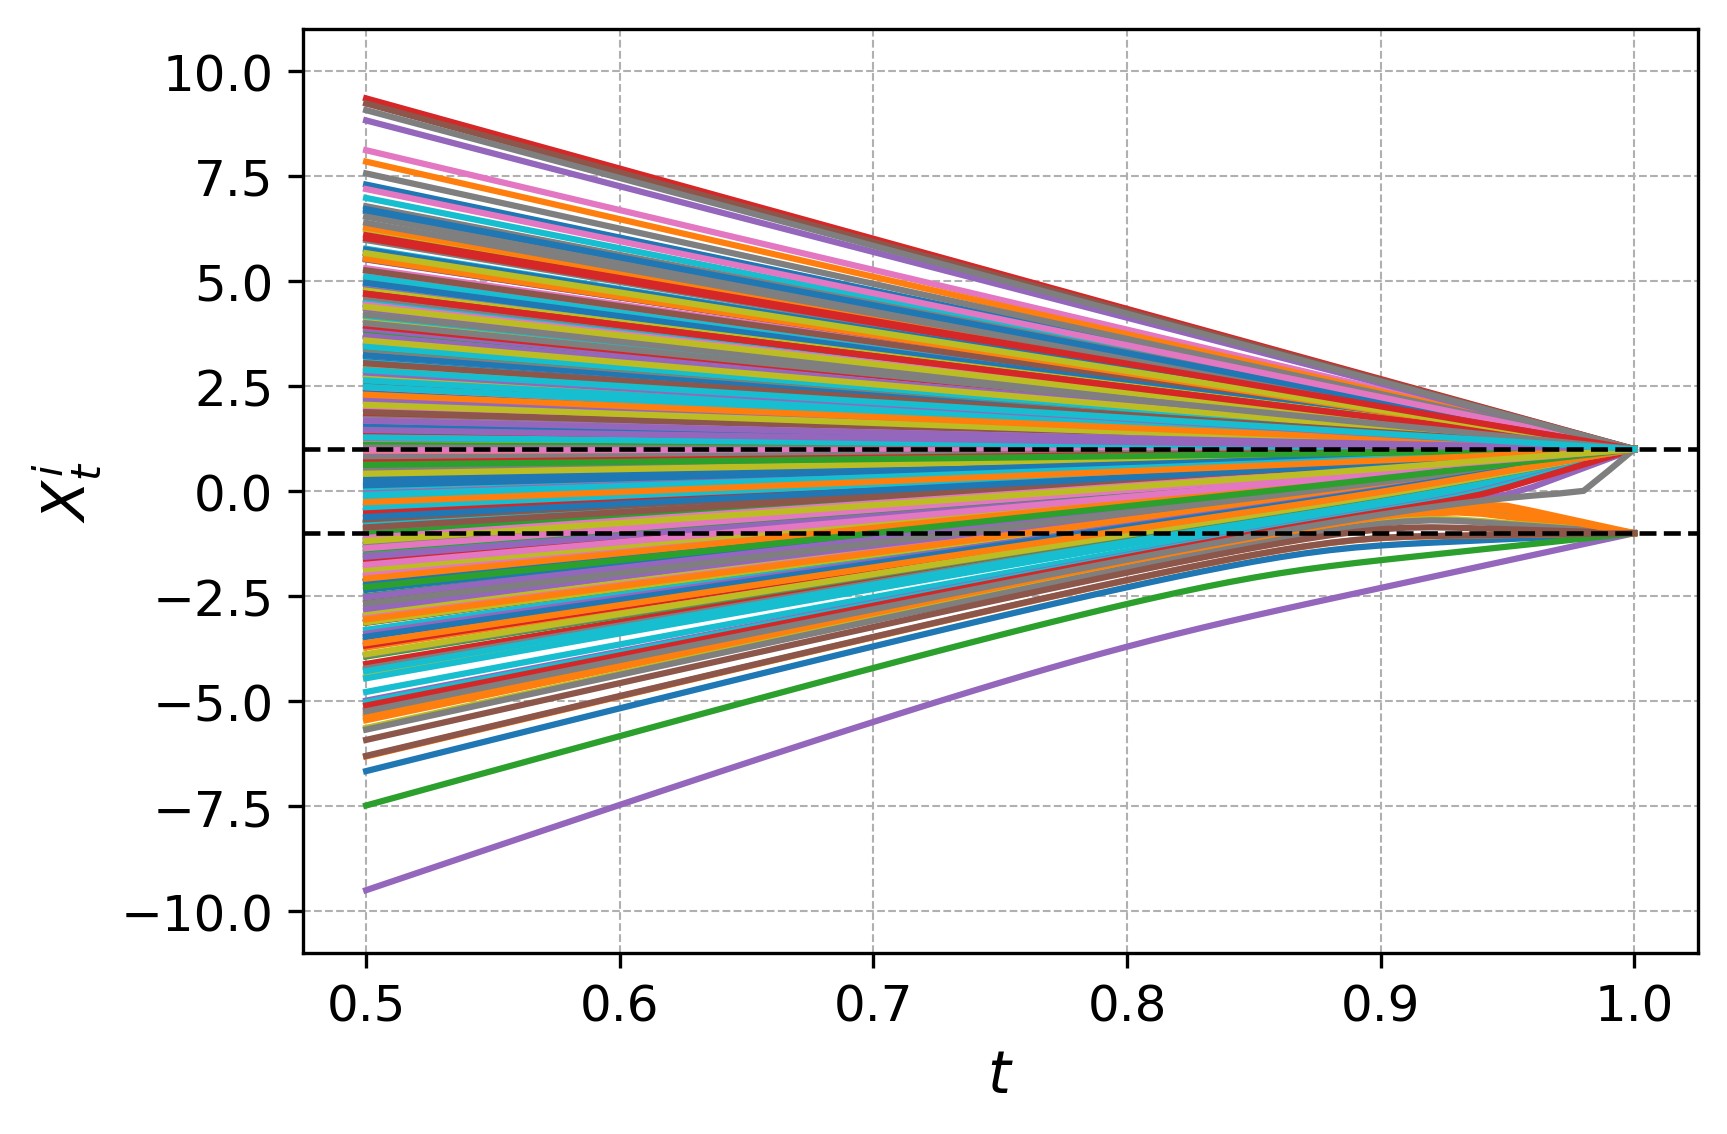

In [7]:
plt.figure(figsize=(6, 4), dpi=300)
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'$X_t^i$', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(ts[50:], xs[50:, 0:500, 0].cpu().numpy());
plt.ylim(-11, 11)
plt.axhline(1, 0, 1, color='black', linestyle='--', lw=1.1)
plt.axhline(-1, 0, 1, color='black', linestyle='--', lw=1.1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('d.png', bbox_inches='tight')